# Homework #2: train a CTC speech recognition model

In lecture you have examined the basics of speech recognition and covered the Connectionist Temporal Classification (CTC) model in detail. You are now ready to train your first "adult" speech recognition system!

In seminar 3 you implemented the CTC forward and backward algorithms in order to calculate the CTC loss and study the diffusion of probability in a CTC trellis. Also you implemented a greedy decoder and a prefix beam-search decoder

In this homework you will implement and train a CTC speech recognition model on a subset of the LibriSpeech corpus. This task will involve:

- Creating a dataloader
- Implementing a and training a Neural Network for CTC
  * DNN
  * LSTM
  * BiLSTM
- Comparing the Properties of these models

# Setup - Install package, download files, etc...

In [ ]:
# uncomment if needed. If you run the notebook in Colab, all these libraries are pre-installed
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

In [1]:
!pip install arpa
!pip install torchmetrics

In [2]:
%%capture
!pip install wandb -qqq

In [3]:
#!L
import math
import os
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm

In [4]:
!curl -L https://raw.githubusercontent.com/severilov/DL-Audio-Course/main/homework/hw2/utils.py > utils.py
import utils as utils   # Change relative path if needed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6770  100  6770    0     0  38505      0 --:--:-- --:--:-- --:--:-- 38685


# Seminar 3 recap: CTC Forward-Backward Algorithm + Soft alignment

## CTC Forward Algorithm

In [5]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [6]:
#!L

def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)
    
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    # Initialze
    # (2L + 1) x T 
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            # First Step
            ch = mod_sequence[s]
            if t == 0:
                if s != 0 and s != 1:
                    alphas[s][t] = NEG_INF
                else:
                    alphas[s][t] = matrix[ch][t]
                
            # Upper diagonal zeros
            elif s < alphas.shape[0] - 2 * (alphas.shape[1]-t)-1:# CONDITION
                alphas[s][t] = NEG_INF
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s][t] = alphas[s][t-1] + matrix[ch][t]
                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s-2]:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                    else:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1], alphas[s-2][t-1]) + matrix[ch][t]
    return alphas

## The CTC Backward Algorithm

In [7]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)
    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            # First Step
            ch = mod_sequence[s]
            if t == matrix.shape[1] - 1:
                if s == betas.shape[0]-1 or s == betas.shape[0]-2:
                    betas[s][t] = 0

            # Lower Diagonal Zeros
            elif s > 2 * t + 1:# CONDITION
                betas[s][t] = NEG_INF
            else:
                if s == len(mod_sequence) - 1:
                    betas[s][t] = betas[s][t+1] + matrix[ch][t]
                elif s == len(mod_sequence) - 2:
                    betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s + 2]:
                            betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                    else:                
                        betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1], betas[s+2][t+1]) + matrix[ch][t]
    return betas

## Soft-Alignment


In [8]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas + betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0)

    return align

## Greedy Best-Path Decoder


In [9]:
#!L
def greedy_decoder(output: torch.Tensor, labels: List[torch.Tensor], 
                   label_lengths: List[int], collapse_repeated: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: list of label indices converted to torch.Tensors
    :param label_lengths: list of label lengths (without padding)
    :param collapse_repeated: whether the repeated characters should be deduplicated
    :return: the result of the decoding and the target sequence
    """
    blank_label = tokenizer.get_symbol_index(BLANK_SYMBOL)

    # Get max classes
    ########################
    arg_maxes = output.argmax(dim=-1)
    ########################

    decodes = []
    targets = []

    # For targets and decodes remove repeats and blanks
    for i, args in enumerate(arg_maxes):
        decode = []
        true_labels = labels[i][:label_lengths[i]].tolist()
        targets.append(tokenizer.indices_to_text(true_labels))

        # Remove repeats, then remove blanks
        for j, index in enumerate(args):
            ########################
            if j != 0:
                if index == args[j-1]:
                    continue
            decode.append(int(index.cpu().detach()))    
            ########################
        ####
        decode = [x for x in decode if x != blank_label]
        ######
        
        decodes.append(tokenizer.indices_to_text(decode))
    return decodes, targets

## Prefix Decoding With LM

In [10]:
LanguageModel = TypeVar("LanguageModel")
# Helper function

class Beam:
    def __init__(self, beam_size: int) -> None:
        self.beam_size = beam_size
        
        fn = lambda : (NEG_INF, NEG_INF)
        
        # Store probs key - prefix, value - p_blank, p_not_blank for ? step
        self.candidates = defaultdict(fn)
        
        # Store sorted by cumulative probability self.candidates
        self.top_candidates_list = [
            (
                tuple(), 
                (0.0, NEG_INF) # log(p_blank) = 0, log(p_not_blank) = -inf
            )
        ]
        
    def get_probs_for_prefix(self, prefix: Tuple[int]) -> Tuple[float, float]:
        p_blank, p_not_blank = self.candidates[prefix]
        return p_blank, p_not_blank
        
    def update_probs_for_prefix(self, prefix: Tuple[int], next_p_blank: float, next_p_not_blank: float) -> None:
        self.candidates[prefix] = (next_p_blank, next_p_not_blank)
        
    def update_top_candidates_list(self) -> None:
        top_candidates = sorted(
            self.candidates.items(), 
            key=lambda x: logsumexp(*x[1]), 
            reverse=True
        )
        self.top_candidates_list = top_candidates[:self.beam_size]
        

def calculate_probability_score_with_lm(lm: LanguageModel, prefix: str) -> float:
    text = tokenizer.indices_to_text(prefix).upper().strip()    # Use upper case for LM and remove the trailing space
    lm_prob = lm.log_p(text)             
    score = lm_prob / np.log10(np.e)    # Convert to natural log, as ARPA LM uses log10   
    return score

In [11]:
#!L

def decode(probs: np.ndarray, beam_size: int = 5, lm: Optional[LanguageModel] = None, 
           prune: float = 1e-5, alpha: float = 0.1, beta: float = 2):
    """
    :param probs: A matrix of shape (T, K) with probability distributions over phonemes at each moment of time.
    :param beam_size: the size of beams
    :lm: arpa language model
    :prune: the minimal probability for a symbol at which it can be added to a prefix
    :alpha: the parameter to de-weight the LM probability
    :beta: the parameter to up-weight the length correction term
    :return: the prefix with the highest sum of probabilites P_blank and P_not_blank
    """
    T, S = probs.shape
    probs = np.log(probs)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    space = tokenizer.get_symbol_index(" ")
    prune = NEG_INF if prune == 0.0 else np.log(prune)
    
    beam = Beam(beam_size)
    # Итерируемся по оси времени
    for t in range(T):
        next_beam = Beam(beam_size)
        
        # Итерируемся по символам
        for s in range(S):
            p = probs[t, s]
            # Prune the vocab - пропускаем символ, если вероятность оказаться в нем слишком мала на t-м щаге
            if p < prune:   
                continue
            
            # Итерируемся по варинатам, в которые можем пойти из текущего символа
            # Сначала идут наиболее вероятные по сумме log(p_blank + p_not_blank) префиксы
            # (p_blank, p_not_blank) - вероятности на предыдущем t-1 шаге
            for prefix, (p_blank, p_not_blank) in beam.top_candidates_list:
                # Текущий символ - бланк 
                if s == blank:
                    # вероятности на текущем шаге
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=logsumexp(p_b, p_blank + p, p_not_blank + p),
                        next_p_not_blank=p_nb
                    )
                    continue

                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                
                # Повторяющийся символ
                if s == end_t:
                    # Предыдущий символ - бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_blank)
                    )
                    # Предудщий символ не бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_not_blank)
                    )
                elif s == space and end_t is not None and lm is not None:
                    # Символ - пробел и не первый, нужно применить языковую модель
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    score = calculate_probability_score_with_lm(lm, n_prefix)
                    length = len(tokenizer.indices_to_text(prefix))
                    
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,         
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(
                            p_nb,
                            p_blank + p + score * alpha + np.log(length) * beta,
                            p_not_blank + p + score * alpha + np.log(length) * beta
                        )  
                    )
                else:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p_blank + p, p_not_blank + p)
                    )

        next_beam.update_top_candidates_list()
        beam = next_beam

    best = beam.top_candidates_list[0]
    return best[0], -logsumexp(*best[1])


def beam_search_decoder(probs: np.ndarray, labels: List[List[int]], label_lengths: List[int], 
                        input_lengths: List[int], lm: LanguageModel, beam_size: int = 5,
                        prune: float = 1e-3, alpha: float = 0.1, beta: float = 0.1):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    
    for i, prob in enumerate(probs):
        targets.append(tokenizer.indices_to_text(labels[i][:label_lengths[i]].tolist()))
        int_seq, _ = decode(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, prune=prune, alpha=alpha, beta=beta)
        decodes.append(tokenizer.indices_to_text(int_seq))
        
    return decodes, targets

# Homework 2 starts here: CTC Speech Recognition System
You can do this notebook in google collab, or use other GPU sources

### Tasks

- (30 points) Train ASR System, WER criterions: 60-50 -- 9 points, 50-40 -- 15 points, 40-35 -- 21 points, <=35 -- 30 points. + 1 bonus point per 1% WER below 30
- (5 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
- (5 points) Compare alignments obtained from DNN, RNN and BiRNN models

## Implementing, training and evaluationg your CTC ASR model

### Create a Dataloader

The first step is to create a dataloader to download and load and preprocess LibriSpeech acoustic data. 

The creative options you have at this stage are:

* The sample rate and number of mel-bins.
* Various forms of data agumentation

In [12]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [05:13<00:00, 20.3MB/s]   
100%|██████████| 331M/331M [00:17<00:00, 20.2MB/s]   


In [13]:
#!L
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchaudio.transforms import FrequencyMasking, TimeMasking

# For train you can use SpecAugment data aug here.
train_audio_transforms = nn.Sequential(
    #Add features transformations here
    MelSpectrogram(sample_rate=16000, n_mels=128),
    AmplitudeToDB(),
    # Can add data augmentation here!
    # <YOUR CODE>
    FrequencyMasking(freq_mask_param=15),
    TimeMasking(time_mask_param=35),
)

test_audio_transforms = nn.Sequential(
    #Add feature transformations here
    ########################
    # YOUR CODE HERE
    MelSpectrogram(sample_rate=16000, n_mels=128),
    AmplitudeToDB()
    ########################
)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [14]:
class Collate:
    def __init__(self, data_type = 'test') -> None:
        super(Collate, self).__init__() 

        self.data_type = data_type

    def __call__(self, data: torchaudio.datasets.librispeech.LIBRISPEECH) -> Tuple[List[torch.Tensor], ...]:
        """
        :param data: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        spectrograms = []
        labels = []
        input_lengths = []
        label_lengths = []
        for (waveform, _, utterance, _, _, _) in data:
            if self.data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            elif self.data_type == 'test':
                spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                raise Exception('data_type should be train or valid')
            spectrograms.append(spec)
            label = torch.Tensor(tokenizer.text_to_indices(utterance.lower()))
            labels.append(label)
            input_lengths.append(spec.shape[0] // 2)
            label_lengths.append(len(label))

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

        return spectrograms, labels, input_lengths, label_lengths


### Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 6 points, 50-40 -- 10 points, 40-35 -- 14 points, <= 35 -- 20 points

In [15]:
#!L

# Our model classes are just examples, you can change them as you want

# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats: int) -> None:
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """

    def __init__(self, in_channels: int, out_channels: int, kernel: int, stride: int, dropout: float, n_feats: int) -> None:
        super(ResidualCNN, self).__init__()

        ########################
        # YOUR CODE HERE
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.dropout1 = nn.Dropout(dropout)
        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.layer_norm2 = CNNLayerNorm(n_feats)
        self.dropout2 = nn.Dropout(dropout)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        ########################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x  # (batch, channel, feature, time)
        # YOUR CODE
        x = self.layer_norm1(x) 
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x  # (batch, channel, feature, time)


class FeatureExtractor(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int,
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(FeatureExtractor, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3 // 2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        # YOUR CODE
        self.rescnn_layers = [ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) for _ in range(n_cnn_layers)]
        self.rescnn_layers = nn.Sequential(*self.rescnn_layers)
        
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim) 
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        return x

########################
# MY ADDITIONAL CODE HERE
class DNN(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.layer_norm = nn.LayerNorm(dim)
        self.linear = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x
########################  

class CTCDNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCDNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                 n_feats, stride, dropout)
        
        ########################
        # YOUR CODE HERE
        self.intermediate_layers = [DNN(rnn_dim, dropout) for _ in range(n_rnn_layers)]
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################
        
        self.classifier = nn.Linear(rnn_dim, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
            x = self.feature_extractor(x)
            x = self.intermediate_layers(x)
            x = self.classifier(x)
            return x
        
########################
# MY ADDITIONAL CODE HERE
class RNN(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first, bidirectional):
        super().__init__()
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.rnn = nn.LSTM(input_size=rnn_dim, hidden_size=hidden_size,
                           num_layers=1, batch_first=batch_first, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        return x
########################  

class CTCRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCRNN, self).__init__()

        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                        n_feats, stride, dropout)

        ########################
        # YOUR CODE HERE
        self.intermediate_layers = [RNN(rnn_dim=rnn_dim, hidden_size=rnn_dim,
                                        dropout=dropout, batch_first=i==0, bidirectional=False) for i in range(n_rnn_layers)]
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################

        self.classifier = nn.Linear(rnn_dim, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
            x = self.feature_extractor(x)
            x = self.intermediate_layers(x)
            x = self.classifier(x)
            return x


class CTCBiRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCBiRNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                 n_feats, stride, dropout)

        ########################
        # YOUR CODE HERE
        self.intermediate_layers = [RNN(rnn_dim=rnn_dim if i==0 else rnn_dim*2, hidden_size=rnn_dim,
                                        dropout=dropout, batch_first=i==0, bidirectional=True) for i in range(n_rnn_layers)]
        self.intermediate_layers = nn.Sequential(*self.intermediate_layers)
        ########################
        self.classifier = nn.Linear(2*rnn_dim, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
            x = self.feature_extractor(x)
            x = self.intermediate_layers(x)
            x = self.classifier(x)
            return x

### Training and Evaluation Code

In [16]:
#!L
from torchmetrics.functional.text import char_error_rate as cer
from torchmetrics.functional.text import word_error_rate as wer

def train(model: nn.Module, device: str, train_loader: data.DataLoader, 
          criterion: nn.Module, optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler, epoch: int) -> None:
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms, input_lengths)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))
            wandb.log({'loss_train': loss.item()})


def test(model: nn.Module, device: str, test_loader: data.DataLoader, 
         criterion: nn.Module, epoch: int, decode: str = 'Greedy', lm: LanguageModel = None, save_path: str = None) -> None:
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms, input_lengths)  # (batch, time, n_class)
            matrix = F.log_softmax(matrix, dim=2)
            probs = F.softmax(matrix,dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                            
            if i == 3:
                np.savetxt(f"{save_path}_matrix_epoch{epoch}.txt", probs[0].cpu().numpy())
                np.savetxt(f"{save_path}_labels_epoch{epoch}.txt", labels[0].cpu().numpy())
                
            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = greedy_decoder(matrix.transpose(0, 1), labels, label_lengths)
            else: # decode == 'BeamSearch':
                ## THIS IS THE FUNCTION YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = beam_search_decoder(probs, labels, label_lengths, input_lengths, lm=lm)
            
            for j in range(len(decoded_preds)):
                # Changed to increase testing speed (used torchmetrics)
#                 test_cer.append(utils.cer(decoded_targets[j], decoded_preds[j]))
#                 test_wer.append(utils.wer(decoded_targets[j], decoded_preds[j]))
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]).item())
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]).item())
                        
    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    wandb.log({'loss_test': test_loss, 'avg_cer': avg_cer, 'avg_wer': avg_wer})
    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))

In [17]:
#!L
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

# Hyperparameters for your model
hparams = {
    "n_cnn_layers": 3, #YOUR CODE
    "n_rnn_layers": 5, #YOUR CODE
    "rnn_dim": 512, #YOUR CODE
    "n_class": 29,
    "n_feats": 128, #YOUR CODE
    "stride": 2, #YOUR CODE
    "dropout": 0.1, #YOUR CODE
    "learning_rate": 5e-4, #YOUR CODE
    "batch_size": 20, #YOUR CODE
    "epochs": 15, #YOUR CODE
}

train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

Only CPU found! 💻


We recommend to use "Weights & Biases" for experiment logging. See their [documentation](https://docs.wandb.ai/) for detais.

In [ ]:
wandb.init(project="hw2-dlaudio",
           group="DNN",
           config=hparams)

## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (5 points)

Train and discuss differences in the different models. 

Compare performance of DNN, RNN and BiRNN models in terms of:
-  WER / CER 
-  Training time
-  Training stability 
-  Any other properties?

In [ ]:
# Train a non-recurrent model
ctc_dnn = CTCDNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
ctc_dnn.to(device)


optimizer = optim.AdamW(ctc_dnn.parameters(), hparams['learning_rate']) # YOUR CODE  - SUGGESTED ADAM/ADAMW
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], epochs=hparams['epochs'],
                                          steps_per_epoch=int(len(train_loader)), anneal_strategy='linear') # YOUR CODE  - SUGGESTED ONE CYCLE

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_dnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn_epoch{epoch}.tar')
    wandb.save(f'ctc_dnn_epoch{epoch}.tar')
    test(ctc_dnn, device, test_loader, criterion, epoch, save_path='dnn')
    wandb.save(f'dnn_labels_epoch{epoch}.txt')
    wandb.save(f'dnn_matrix_epoch{epoch}.txt')

utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn.tar')


In [ ]:
wandb.finish()

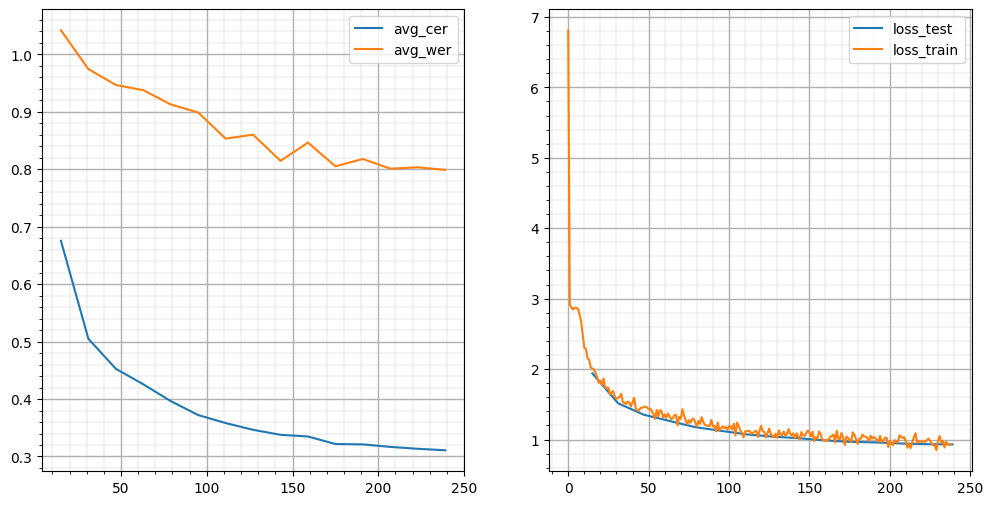

In [87]:
runs = []

api = wandb.Api()
run = api.run("/gregkseno/hw2-dlaudio/runs/6nhlrma0")
runs.append(run)
if run.state == "finished":
    history = run.history()
    fig, axs = plt.subplots(1, 2,figsize=(12, 6))
    for i, pair in enumerate([['avg_cer', 'avg_wer'], ['loss_test', 'loss_train']]):
        for statistic in pair:
            s = history[statistic]
            axs[i].plot(s[~s.isnull()], label=statistic)
        axs[i].grid(which = "major", linewidth = 1)
        axs[i].grid(which = "minor", linewidth = 0.2)
        axs[i].minorticks_on()
        axs[i].tick_params(which = "minor")
        axs[i].legend(loc="upper right")
    plt.show()

In [ ]:
wandb.init(project="hw2-dlaudio", 
           group="RNN",
           config=hparams)

In [ ]:
# Train a  recurrent model
ctc_rnn = CTCRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.AdamW(ctc_rnn.parameters(), hparams['learning_rate']) # YOUR CODE  - SUGGESTED ADAM/ADAMW
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], epochs=hparams['epochs'],
                                          steps_per_epoch=int(len(train_loader)), anneal_strategy='linear') # YOUR CODE  - SUGGESTED ONE CYCLE

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_rnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn_epoch{epoch}.tar')
    wandb.save(f'ctc_rnn_epoch{epoch}.tar')
    test(ctc_rnn, device, test_loader, criterion, epoch, save_path='rnn')
    wandb.save(f'rnn_labels_epoch{epoch}.txt')
    wandb.save(f'rnn_matrix_epoch{epoch}.txt')

utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn.tar')


In [ ]:
wandb.finish()

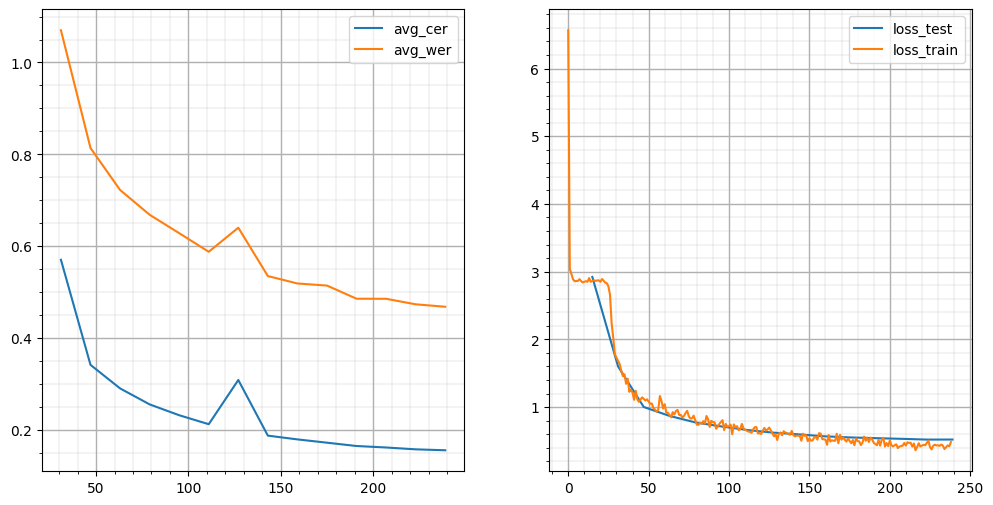

In [88]:
api = wandb.Api()
run = api.run("/gregkseno/hw2-dlaudio/runs/vq4tv6mi")
runs.append(run)
if run.state == "finished":
    history = run.history()
    fig, axs = plt.subplots(1, 2,figsize=(12, 6))
    for i, pair in enumerate([['avg_cer', 'avg_wer'], ['loss_test', 'loss_train']]):
        for statistic in pair:
            s = history[statistic]
            s.replace(['Infinity'], np.nan, inplace=True)
            axs[i].plot(s[~s.isnull()], label=statistic)
        axs[i].grid(which = "major", linewidth = 1)
        axs[i].grid(which = "minor", linewidth = 0.2)
        axs[i].minorticks_on()
        axs[i].tick_params(which = "minor")
        axs[i].legend(loc="upper right")
    plt.show()

In [ ]:
wandb.init(project="hw2-dlaudio", 
           group="BiRNN",
           config=hparams)

In [ ]:
# Train a  recurrent model
ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.AdamW(ctc_birnn.parameters(), hparams['learning_rate']) # YOUR CODE  - SUGGESTED ADAM/ADAMW
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], epochs=hparams['epochs'],
                                          steps_per_epoch=int(len(train_loader)), anneal_strategy='linear') # YOUR CODE  - SUGGESTED ONE CYCLE

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
    wandb.save(f'ctc_birnn_epoch{epoch}.tar')
    test(ctc_birnn, device, test_loader, criterion, epoch, save_path='birnn')
    wandb.save(f'birnn_labels_epoch{epoch}.txt')
    wandb.save(f'birnn_matrix_epoch{epoch}.txt')

utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn.tar')

In [ ]:
wandb.finish()

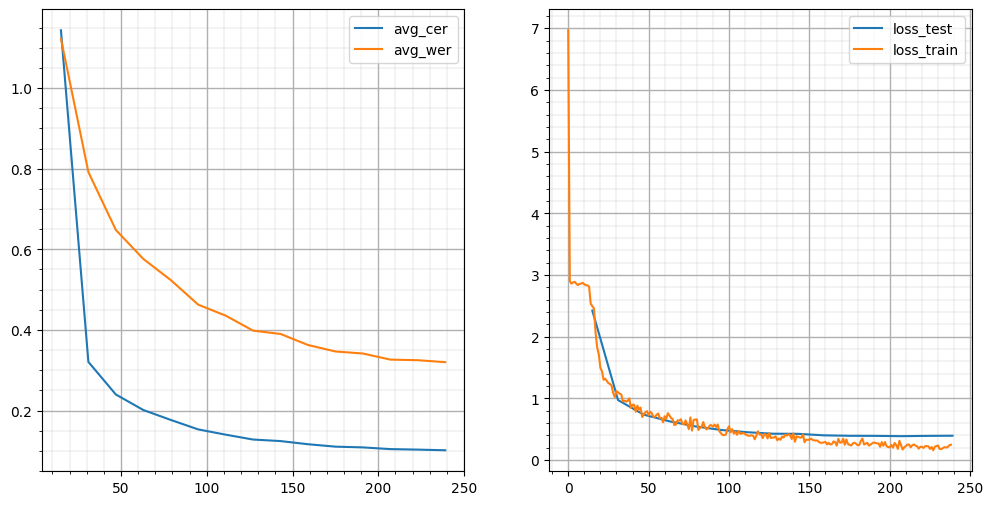

In [89]:
api = wandb.Api()
run = api.run("/gregkseno/hw2-dlaudio/runs/3ola52h6")
runs.append(run)
if run.state == "finished":
    history = run.history()
    fig, axs = plt.subplots(1, 2,figsize=(12, 6))
    for i, pair in enumerate([['avg_cer', 'avg_wer'], ['loss_test', 'loss_train']]):
        for statistic in pair:
            s = history[statistic]
            axs[i].plot(s[~s.isnull()], label=statistic)
        axs[i].grid(which = "major", linewidth = 1)
        axs[i].grid(which = "minor", linewidth = 0.2)
        axs[i].minorticks_on()
        axs[i].tick_params(which = "minor")
        axs[i].legend(loc="upper right")
    plt.show()

## Test all models with different decoder

Download all models, matrices and labels from wandb

In [92]:
for run in runs:
    for file in tqdm(run.files()):
        file.download(exist_ok=True)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Load weights

In [105]:
epoch = 15
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')

ctc_dnn = CTCDNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)
utils.load_checkpoint(ctc_dnn, '/kaggle/working', f'ctc_dnn_epoch{epoch}.tar', device)

ctc_rnn = CTCRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)
utils.load_checkpoint(ctc_rnn, '/kaggle/working', f'ctc_rnn_epoch{epoch}.tar', device)

ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)
utils.load_checkpoint(ctc_birnn, '/kaggle/working', f'ctc_birnn_epoch{epoch}.tar', device)

In [107]:
print('########## DNN ##########')
print('Greedy')
wandb.init(project="hw2-dlaudio", name="Greedy", group="DNN", config=hparams)
test(ctc_dnn, device, test_loader, criterion, epoch, save_path='dnn')
wandb.finish()
print('BeamSearch')
wandb.init(project="hw2-dlaudio", name="BeamSearch", group="DNN", config=hparams)
test(ctc_dnn, device, test_loader, criterion, epoch, save_path='dnn', decode='BeamSearch')
wandb.finish()

print('########## RNN ##########')
print('Greedy')
wandb.init(project="hw2-dlaudio", name="Greedy", group="RNN", config=hparams)
test(ctc_rnn, device, test_loader, criterion, epoch, save_path='rnn')
wandb.finish()
print('BeamSearch')
wandb.init(project="hw2-dlaudio", name="BeamSearch", group="RNN", config=hparams)
test(ctc_rnn, device, test_loader, criterion, epoch, save_path='rnn', decode='BeamSearch')
wandb.finish()

print('######### BiRNN #########')
print('Greedy')
wandb.init(project="hw2-dlaudio", name="Greedy", group="BiRNN", config=hparams)
test(ctc_birnn, device, test_loader, criterion, epoch, save_path='birnn')
wandb.finish()
print('BeamSearch')
wandb.init(project="hw2-dlaudio", name="BeamSearch", group="BiRNN", config=hparams)
test(ctc_birnn, device, test_loader, criterion, epoch, save_path='birnn', decode='BeamSearch')
wandb.finish()

wandb: Currently logged in as: gregkseno. Use `wandb login --relogin` to force relogin


########## DNN ##########
Greedy


Beginning eval...
Epoch: 15, Test set: Average loss: 0.9305, Average CER: 0.310825 Average WER: 0.7989



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.31082
avg_wer,0.79893
loss_test,0.93054


BeamSearch


Beginning eval...
Epoch: 15, Test set: Average loss: 0.9305, Average CER: 0.303628 Average WER: 0.7772



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.30363
avg_wer,0.77724
loss_test,0.93054


########## RNN ##########
Greedy


Beginning eval...
Epoch: 15, Test set: Average loss: 0.5204, Average CER: 0.155659 Average WER: 0.4681



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.15566
avg_wer,0.46814
loss_test,0.52038


BeamSearch


Beginning eval...
Epoch: 15, Test set: Average loss: 0.5204, Average CER: 0.151714 Average WER: 0.4569



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.15171
avg_wer,0.45694
loss_test,0.52038


######### BiRNN #########
Greedy


Beginning eval...
Epoch: 15, Test set: Average loss: 0.3964, Average CER: 0.101456 Average WER: 0.3201



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.10146
avg_wer,0.3201
loss_test,0.39638


BeamSearch


Beginning eval...
Epoch: 15, Test set: Average loss: 0.3964, Average CER: 0.099673 Average WER: 0.3135



avg_cer,▁
avg_wer,▁
loss_test,▁
avg_cer,0.09967
avg_wer,0.31347
loss_test,0.39638


WER/CER comparison


|        **Model**       | **WER**  | **CER**  |
|--------------------|------|------|
| DNN (Geedy)        | 0.80 | 0.31 |
| DNN (BeamSearch)   | 0.78 | 0.30 |
| RNN (Geedy)        | 0.47 | 0.16 |
| RNN (BeamSearch)   | 0.46 | 0.15 |
| BiRNN (Geedy)      | 0.32 | 0.10 |
| BiRNN (BeamSearch) | 0.31 | 0.10 |


## Compare alignments (5 points)

In this section you should compare alignments obtained from different models (DNN / RNN / BiRNN). For example, you can show:

- Examples of alignments and their analysis. 
- Differencies in the properties of alignment distributions over the dataset. 
- Dynamic of alignments during training (from checkpoints). 
- Connection between alignments and model loss. 
- Which models use the most blanks and why?

In [ ]:
!mkdir animation
for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    # Some code to get you started.
    dnn_matrix = np.loadtxt(f'dnn_matrix_epoch{epoch}.txt').T
    rnn_matrix = np.loadtxt(f'rnn_matrix_epoch{epoch}.txt').T
    birnn_matrix = np.loadtxt(f'birnn_matrix_epoch{epoch}.txt').T

    dnn_labels = np.loadtxt(f'dnn_labels_epoch{epoch}.txt', dtype=np.int32)
    dnn_labels = dnn_labels[dnn_labels != 0]
    rnn_labels = np.loadtxt(f'rnn_labels_epoch{epoch}.txt', dtype=np.int32)
    rnn_labels = rnn_labels[rnn_labels != 0]
    birnn_labels = np.loadtxt(f'birnn_labels_epoch{epoch}.txt', dtype=np.int32)
    birnn_labels = birnn_labels[birnn_labels != 0]

    dnn_align = soft_alignment(dnn_labels, dnn_matrix)
    rnn_align = soft_alignment(rnn_labels, rnn_matrix)
    birnn_align = soft_alignment(birnn_labels, birnn_matrix)

    f, ax = plt.subplots(3, 2, dpi=75, figsize=(10, 10))
    f.suptitle(f'Epoch: {epoch}')

    im = ax[0,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
    ax[0,0].set_title("DNN Alignment")
    ax[0,0].set_ylabel("Phonemes")
    ax[0,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[0,0])

    im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
    ax[0,1].set_title("DNN Alignment in log scale")
    ax[0,1].set_ylabel("Phonemes")
    ax[0,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[0,1])

    im = ax[1,0].imshow(rnn_align, aspect='auto', interpolation='nearest')
    ax[1,0].set_title("RNN Alignment")
    ax[1,0].set_ylabel("Phonemes")
    ax[1,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[1,0])

    im = ax[1,1].imshow(np.log(rnn_align), aspect='auto', interpolation='nearest')
    ax[1,1].set_title("RNN Alignment in log scale")
    ax[1,1].set_ylabel("Phonemes")
    ax[1,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[1,1])

    im = ax[2,0].imshow(birnn_align, aspect='auto', interpolation='nearest')
    ax[2,0].set_title("BiRNN Alignment")
    ax[2,0].set_ylabel("Phonemes")
    ax[2,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[2,0])

    im = ax[2,1].imshow(np.log(birnn_align), aspect='auto', interpolation='nearest')
    ax[2,1].set_title("BiRNN Alignment in log scale")
    ax[2,1].set_ylabel("Phonemes")
    ax[2,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[2,1])

    plt.tight_layout()
    plt.savefig(f'animation/fig-{epoch}.jpg')

In [153]:
import imageio

pics_dir = 'animation'
images = []
delay = 10
for epoch in range(delay, (hparams['epochs'] + 1)*delay):
    images.append(imageio.imread(f'animation/fig-{epoch // delay}.jpg'))
    
imageio.mimsave('animation/dynamic.gif', images)

/tmp/ipykernel_47/105001650.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'animation/fig-{epoch // delay}.jpg'))


<img src="https://drive.google.com/uc?id=1wwzHMEMZOOMUP9_7HP_-SZPxrO3aMPfk">